<a href="https://colab.research.google.com/github/lechemrc/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module1-statistics-probability-and-inference/LS_DS_131_Statistics_Probability_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 1 Sprint 3 Assignment 1*

# Apply the t-test to real data

Your assignment is to determine which issues have "statistically significant" differences between political parties in this [1980s congressional voting data](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records). The data consists of 435 instances (one for each congressperson), a class (democrat or republican), and 16 binary attributes (yes or no for voting for or against certain issues). Be aware - there are missing values!

Your goals:

1. Load and clean the data (or determine the best method to drop observations when running tests)
2. Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01
3. Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01
4. Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)

Note that this data will involve *2 sample* t-tests, because you're comparing averages across two groups (republicans and democrats) rather than a single group against a null hypothesis.

Stretch goals:

1. Refactor your code into functions so it's easy to rerun with arbitrary variables
2. Apply hypothesis testing to your personal project data (for the purposes of this notebook you can type a summary of the hypothesis you formed and tested)

### Importing Data

In [52]:
import pandas as pd

!curl https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.names

1. Title: 1984 United States Congressional Voting Records Database

2. Source Information:
    (a) Source:  Congressional Quarterly Almanac, 98th Congress, 
                 2nd session 1984, Volume XL: Congressional Quarterly Inc. 
                 Washington, D.C., 1985.
    (b) Donor: Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
    (c) Date: 27 April 1987 

3. Past Usage
   - Publications
     1. Schlimmer, J. C. (1987).  Concept acquisition through 
        representational adjustment.  Doctoral dissertation, Department of 
        Information and Computer Science, University of California, Irvine, CA.
        -- Results: about 90%-95% accuracy appears to be STAGGER's asymptote
     - Predicted attribute: party affiliation (2 classes)

4. Relevant Information:
      This data set includes votes for each of the U.S. House of
      Representatives Congressmen on the 16 key votes identified by the
      CQA.  The CQA lists nine different types of votes: voted for, paired
      

In [53]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'
df = pd.read_csv(url, header=None)
print(df.shape)
df.head()

(435, 17)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


### Naming the columns to match attributes from the names file

In [54]:
columns = ['class_name', 'handicapped_infants', 'water_project_cost_sharing', 
           'adoption_of_the_budget_resolution', 'physician_fee_freeze', 
           'el_salvador_aid', 'religious_groups_in_schools', 
           'anti_satellite_test_ban', 'aid_to_nicaraguan_contras', 'mx_missile', 
           'immigration', 'synfuels_corporation_cutback', 'education_spending', 
           'superfund_right_to_sue', 'crime', 'duty_free_exports', 
           'export_administration_act_south_africa']

df.columns = columns
df.head()

,class_name,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


### Exploring and manipulating the data

In [55]:
df.isna().sum()

class_name                                0
handicapped_infants                       0
water_project_cost_sharing                0
adoption_of_the_budget_resolution         0
physician_fee_freeze                      0
el_salvador_aid                           0
religious_groups_in_schools               0
anti_satellite_test_ban                   0
aid_to_nicaraguan_contras                 0
mx_missile                                0
immigration                               0
synfuels_corporation_cutback              0
education_spending                        0
superfund_right_to_sue                    0
crime                                     0
duty_free_exports                         0
export_administration_act_south_africa    0
dtype: int64

In [56]:
# This was just to visualize the y, n votes for each bill 

votes = []
for feat in df.columns:
  a = df[feat].value_counts(dropna=False).tolist()
  votes.append(a)

  
votes = pd.DataFrame(votes)[1:]
col = ['y', 'n', '?']
votes.columns = col
votes

,y,n,?
1,236,187,12.0
2,195,192,48.0
3,253,171,11.0
4,247,177,11.0
5,212,208,15.0
6,272,152,11.0
7,239,182,14.0
8,242,178,15.0
9,207,206,22.0
10,216,212,7.0


In [57]:
df.head()

,class_name,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [0]:
# testing how to combine the political party with a vote

# df['handicapped_infants_vote'] = df['class_name'].astype(str) + '_' + df['handicapped_infants']
# df['handicapped_infants_vote'].value_counts()

In [0]:
# replacing y with 1, no with 0, no vote with .5 as the avg of the two 
df.replace(to_replace=['n', 'y', '?'], value=[1, 0, .5], inplace=True)
df.head()

# separating democrat votes from republican votes
democrats = df.loc[df['class_name']=='democrat']
republicans = df.loc[df['class_name']=='republican']

In [60]:
democrats.head()

,class_name,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
2,democrat,0.5,0.0,0.0,0.5,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
3,democrat,1.0,0.0,0.0,1.0,0.5,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,democrat,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0
5,democrat,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
6,democrat,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.0,0.0,0.0


In [61]:
democrats.describe()

,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
count,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.00000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000
mean,0.398876,0.498127,0.121723,0.932584,0.771536,0.522472,0.235955,0.176030,0.26030,0.528090,0.494382,0.831461,0.698502,0.644195,0.370787,0.198502
std,0.481889,0.473941,0.317379,0.235772,0.407005,0.491909,0.416460,0.376602,0.41882,0.496375,0.489520,0.351772,0.444174,0.469756,0.468128,0.287453
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.750000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.500000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.500000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.250000,0.000000,0.50000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [62]:
republicans.describe()

,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.00000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,0.806548,0.494048,0.857143,0.020833,0.056548,0.107143,0.75000,0.824405,0.877976,0.443452,0.848214,0.157738,0.160714,0.038690,0.880952,0.363095
std,0.390476,0.470660,0.342336,0.126611,0.221762,0.305356,0.42384,0.359390,0.321379,0.493750,0.340653,0.337922,0.347452,0.164126,0.295870,0.446887
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.50000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,0.500000,1.000000,0.000000,0.000000,0.000000,1.00000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
full = pd.concat([democrats, republicans])
print(full.head())
full.tail()

  class_name  ...  export_administration_act_south_africa
2   democrat  ...                                     1.0
3   democrat  ...                                     0.0
4   democrat  ...                                     0.0
5   democrat  ...                                     0.0
6   democrat  ...                                     0.0

[5 rows x 17 columns]


,class_name,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
427,republican,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
430,republican,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
432,republican,1.0,0.5,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
433,republican,1.0,1.0,1.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,1.0,0.0,0.0,0.0,1.0,0.0
434,republican,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.5,1.0


### Performing statistical analysis on the data

In [0]:
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [65]:
# Finding the mean and standard deviation of both sets of voting

for val in [democrats, republicans]:
  print(f'Mean \n{val.mean()}')
  print(f'StDev \n{val.std()}')
  print('---------')

Mean 
handicapped_infants                       0.398876
water_project_cost_sharing                0.498127
adoption_of_the_budget_resolution         0.121723
physician_fee_freeze                      0.932584
el_salvador_aid                           0.771536
religious_groups_in_schools               0.522472
anti_satellite_test_ban                   0.235955
aid_to_nicaraguan_contras                 0.176030
mx_missile                                0.260300
immigration                               0.528090
synfuels_corporation_cutback              0.494382
education_spending                        0.831461
superfund_right_to_sue                    0.698502
crime                                     0.644195
duty_free_exports                         0.370787
export_administration_act_south_africa    0.198502
dtype: float64
StDev 
handicapped_infants                       0.481889
water_project_cost_sharing                0.473941
adoption_of_the_budget_resolution         0.317379
phy

In [66]:
# creating a dictionary to create the new dataframe
data = {'d_mean': democrats.mean(), 'd_stdev': democrats.std(), 
        'r_mean': republicans.mean(), 'r_stdev': republicans.std()}

# creating the dataframe
mean_std = pd.DataFrame(data)

mean_std

,d_mean,d_stdev,r_mean,r_stdev
handicapped_infants,0.398876,0.481889,0.806548,0.390476
water_project_cost_sharing,0.498127,0.473941,0.494048,0.470660
adoption_of_the_budget_resolution,0.121723,0.317379,0.857143,0.342336
physician_fee_freeze,0.932584,0.235772,0.020833,0.126611
el_salvador_aid,0.771536,0.407005,0.056548,0.221762
religious_groups_in_schools,0.522472,0.491909,0.107143,0.305356
anti_satellite_test_ban,0.235955,0.416460,0.750000,0.423840
aid_to_nicaraguan_contras,0.176030,0.376602,0.824405,0.359390
mx_missile,0.260300,0.418820,0.877976,0.321379
immigration,0.528090,0.496375,0.443452,0.493750


In [67]:
# I'm testing how to find tstat and pvalue in this particular block of code
# the next block will attempt to iterate through all the bills

# this gives me my t-stat and pvalue for the given bill
tstat, pvalue = ttest_ind(democrats['handicapped_infants'], 
                          republicans['handicapped_infants'])
print(democrats.columns.values[1])
print('T-Stat: ' + str(tstat))
print('P Value: ' + str(pvalue))
print('Probability: ' + str(100 - pvalue))

# this tells us wether to accept of reject the null hypothesis, or in other
# words, if this vote holds statistical significance (if it does, reject)
if ((100 - pvalue) >= 95):
  print('REJECT NULL HYPOTHESIS')
else: 
  print('FAIL TO REJECT NULL HYPOTHESIS')

handicapped_infants
T-Stat: -9.22317772154614
P Value: 1.2761169357253626e-18
Probability: 100.0
REJECT NULL HYPOTHESIS


In [70]:
democrats.columns

Index(['class_name', 'handicapped_infants', 'water_project_cost_sharing',
       'adoption_of_the_budget_resolution', 'physician_fee_freeze',
       'el_salvador_aid', 'religious_groups_in_schools',
       'anti_satellite_test_ban', 'aid_to_nicaraguan_contras', 'mx_missile',
       'immigration', 'synfuels_corporation_cutback', 'education_spending',
       'superfund_right_to_sue', 'crime', 'duty_free_exports',
       'export_administration_act_south_africa'],
      dtype='object')

In [69]:
democrats.columns[1:]

Index(['handicapped_infants', 'water_project_cost_sharing',
       'adoption_of_the_budget_resolution', 'physician_fee_freeze',
       'el_salvador_aid', 'religious_groups_in_schools',
       'anti_satellite_test_ban', 'aid_to_nicaraguan_contras', 'mx_missile',
       'immigration', 'synfuels_corporation_cutback', 'education_spending',
       'superfund_right_to_sue', 'crime', 'duty_free_exports',
       'export_administration_act_south_africa'],
      dtype='object')

### Visualizing the data

In [0]:
sns.barplot(democrats['physician_fee_freeze'], color='r')
sns.barplot(republicans['physician_fee_freeze'], color='b')

# this probably isn't the most helpful visualization in the end. 

(array([149.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,  17.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

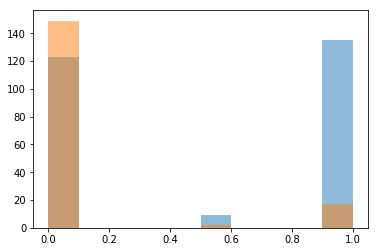

In [91]:
plt.hist(democrats['religious_groups_in_schools'], alpha=0.5)
plt.hist(republicans['religious_groups_in_schools'], alpha=0.5)

In [0]:
# p-value: how unlikely something is to have that distribution

In [126]:
# Testing a block of code

# d_sample_mean = []
# r_sample_mean = []
# for x in range(0,1):
#     d_sample = democrats[feat].sample(50).values
#     r_sample = republicans[feat].sample(50).values
#     d_sample_mean.append(d_sample)
#     r_sample_mean.append(r_sample)
    
# d_sample_mean

[array([0. , 0. , 1. , 0.5, 1. , 1. , 0.5, 1. , 0. , 0. , 0. , 1. , 1. ,
        1. , 0. , 0. , 1. , 0. , 1. , 1. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 1. , 0. , 1. , 1. , 0. , 0. , 0. , 0. , 1. , 1. , 1. , 0. ,
        0. , 0. , 0. , 1. , 0. , 0. , 0. , 1. , 0. , 1. , 1. ])]

### Final visual and information


handicapped_infants
T-Stat: [-21.07859301]
P Value: [3.18489488e-89]
Confidence: [100.]%


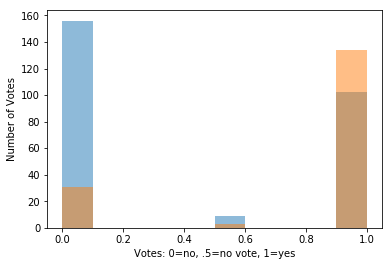

REJECT null hypothesis


-----------------------

water_project_cost_sharing
T-Stat: [-0.26024694]
P Value: [0.79470011]
Confidence: [99.20529989]%


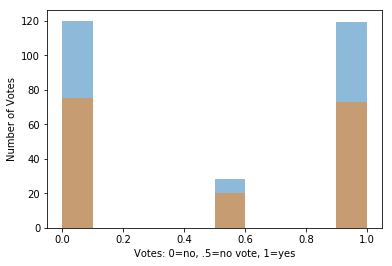

FAIL TO REJECT null hypothesis


-----------------------

adoption_of_the_budget_resolution
T-Stat: [-49.53194604]
P Value: [0.]
Confidence: [100.]%


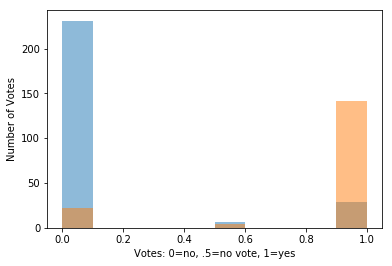

REJECT null hypothesis


-----------------------

physician_fee_freeze
T-Stat: [107.32755988]
P Value: [0.]
Confidence: [100.]%


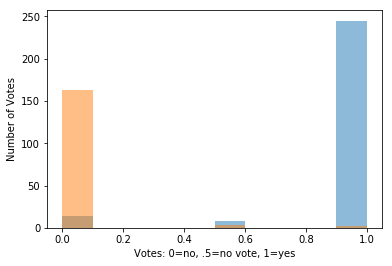

REJECT null hypothesis


-----------------------

el_salvador_aid
T-Stat: [50.78117759]
P Value: [0.]
Confidence: [100.]%


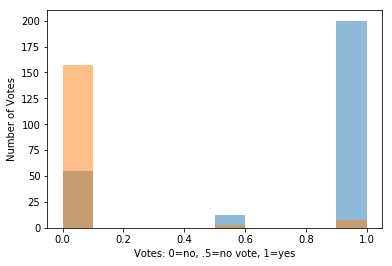

REJECT null hypothesis


-----------------------

religious_groups_in_schools
T-Stat: [22.99250422]
P Value: [5.51954896e-104]
Confidence: [100.]%


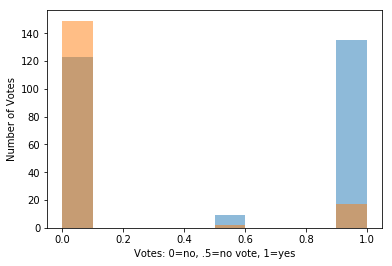

REJECT null hypothesis


-----------------------

anti_satellite_test_ban
T-Stat: [-27.2459631]
P Value: [2.90036002e-139]
Confidence: [100.]%


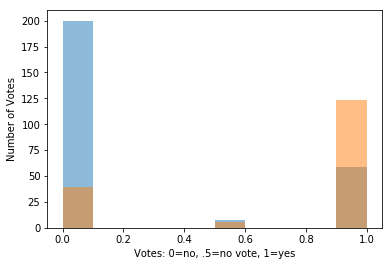

REJECT null hypothesis


-----------------------

aid_to_nicaraguan_contras
T-Stat: [-42.45868857]
P Value: [2.62956205e-281]
Confidence: [100.]%


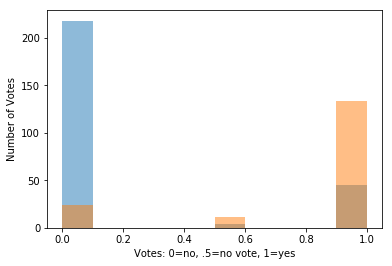

REJECT null hypothesis


-----------------------

mx_missile
T-Stat: [-35.70282563]
P Value: [2.29450518e-216]
Confidence: [100.]%


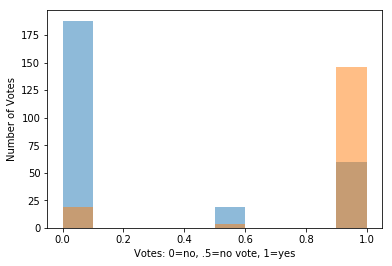

REJECT null hypothesis


-----------------------

immigration
T-Stat: [4.36411871]
P Value: [1.34147665e-05]
Confidence: [99.99998659]%


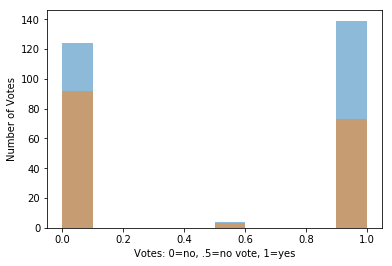

REJECT null hypothesis


-----------------------

synfuels_corporation_cutback
T-Stat: [-18.87171402]
P Value: [3.123375e-73]
Confidence: [100.]%


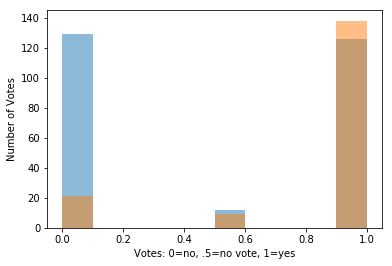

REJECT null hypothesis


-----------------------

education_spending
T-Stat: [42.58728767]
P Value: [1.48775704e-282]
Confidence: [100.]%


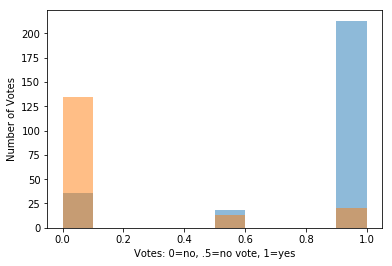

REJECT null hypothesis


-----------------------

superfund_right_to_sue
T-Stat: [32.07194034]
P Value: [2.01834091e-182]
Confidence: [100.]%


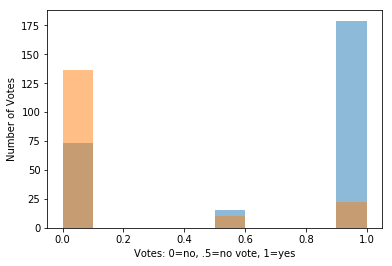

REJECT null hypothesis


-----------------------

crime
T-Stat: [37.30177363]
P Value: [1.39296329e-231]
Confidence: [100.]%


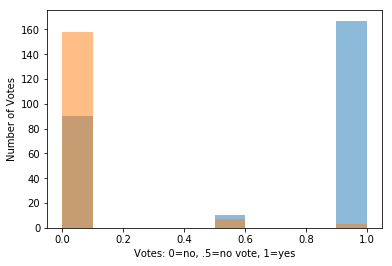

REJECT null hypothesis


-----------------------

duty_free_exports
T-Stat: [-30.09555127]
P Value: [2.01315084e-164]
Confidence: [100.]%


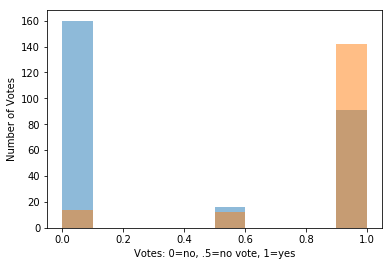

REJECT null hypothesis


-----------------------

export_administration_act_south_africa
T-Stat: [-8.97461591]
P Value: [6.39298934e-19]
Confidence: [100.]%


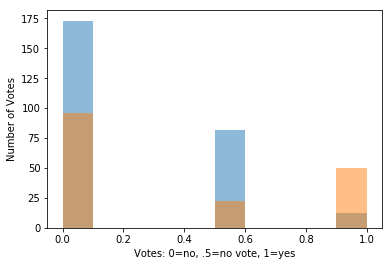

REJECT null hypothesis


-----------------------



In [137]:
n = 1
for feat in democrats.columns[1:]:
  d_sample_mean = []
  r_sample_mean = []
  for x in range(0,1000):
    d_sample = democrats[feat].sample().values
    r_sample = republicans[feat].sample().values
    d_sample_mean.append(d_sample)
    r_sample_mean.append(r_sample)

  tstat, pvalue = ttest_ind(d_sample_mean, 
                          r_sample_mean)
  
# This was to test the output and make sure it worked
#   print(d_sample)
#   print(d_sample_mean) 
    
    # This outputs the values
  print(democrats.columns.values[n])
  print('T-Stat: ' + str(tstat))
  print('P Value: ' + str(pvalue))
  print('Confidence: ' + str(100 - pvalue) + '%')
  n += 1
  
  #plot a graph for each one
  plt.hist(democrats[feat], alpha=0.5)
  plt.hist(republicans[feat], alpha=0.5)
  plt.xlabel('Votes: 0=no, .5=no vote, 1=yes')
  plt.ylabel('Number of Votes')
#   plt.xticks(['no', 'null', 'yes'])
  plt.show();
  
      
  # this tests for 99% confidence
  if (pvalue <= 0.01):
    print('REJECT null hypothesis')
  else: 
    print('FAIL TO REJECT null hypothesis')
  print('\n\n-----------------------\n')
  